## 作業

請結合前面的知識與程式碼，比較 Dropout, Regularization 與 Batch Normalization 的組合對訓練的結果與影響。

In [1]:
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.regularizers import l2
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
class BuildParam:
    
    def __init__(self, should_regularize, should_batch_normalize, should_dropout):
        self.should_dropout = should_dropout
        self.should_regularize = should_regularize
        self.should_batch_normalize = should_batch_normalize

    @property
    def label(self):
        names = ('dp', 'l2', 'bn',)
        switchs = (self.should_dropout, self.should_regularize, self.should_batch_normalize,)
        return '-'.join(['exp'] + [names[i] if enable else '--' for i, enable in enumerate(switchs)])

def train_models(X_train, y_train, X_test, y_test, build_params, neuron_numbers=(512, 256, 128,),
                 epochs=50, batch_size=256, momentum=0.95, learning_rate=1e-3):
    train_histories = []
    for i, build_param in enumerate(build_params):
        print('Experiment with label: {}'.format(build_param.label))
        backend.clear_session() # 清掉舊的 Graph
        model = build_model(X_train, X_train.shape[-1:], 10, neuron_numbers, build_param)
        model.summary()
        model.compile(optimizer=SGD(lr=learning_rate, momentum=momentum, nesterov=True),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test,),
                  shuffle=True, verbose=2)
        train_histories.append(model.history)
    return train_histories

def build_model(x, input_shape, output_units, neuron_numbers, build_param):
    main_input = hidden_input = Input(shape=input_shape, name='main_input')
    for i, neuron_number in enumerate(neuron_numbers):
        dense_param = {'units': neuron_number, 'activation': 'relu', 'name': f'hidden_layer{i}'}
        dense_param = {**dense_param, **({'kernel_regularizer': l2(l=1e-8)} if build_param.should_regularize else {})}
        hidden_input = Dense(**dense_param)(hidden_input)
        hidden_input = BatchNormalization()(hidden_input) if build_param.should_batch_normalize else hidden_input
        hidden_input = Dropout(0.2)(hidden_input) if build_param.should_dropout else hidden_input
    main_output = Dense(units=output_units, activation='softmax', name='main_output')(hidden_input)
    return Model(inputs=[main_input], outputs=[main_output])

def show_train_histories(train_histories, train_name, val_name, colors, build_params):
    plt.figure(figsize=(16, 9,))
    for i, train_history in enumerate(train_histories):
        show_train_history(train_history, train_name, val_name, colors[i], build_params[i])
    plt.xlabel('Epoch')
    plt.ylabel(train_name)
    plt.title('Train History')
    plt.legend()
    plt.show()

def show_train_history(train_history, train_name, val_name, color, build_param):
    plt.plot(train_history.history[train_name], '-', label='exp: {}'.format(build_param.label), color=color)
    plt.plot(train_history.history[val_name], '--', label='exp: {}'.format(build_param.label), color=color)

## 訓練模型

In [7]:
## 設定超參數
build_params = [BuildParam(*switchs) for switchs in itertools.product((True, False,), repeat=3)]
build_params.reverse()

## 設定繪圖參數
colors = [f'C{i}' for i in range(len(build_params))]

In [8]:
train_histories = train_models(X_train, y_train, X_test, y_test, build_params)

Experiment with label: exp---------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
main_output (Dense)          (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 11s - loss: 2.0246 - acc: 0.2781

Epoch 18/50
 - 12s - loss: 1.5028 - acc: 0.4644 - val_loss: 1.4436 - val_acc: 0.4864
Epoch 19/50
 - 13s - loss: 1.4865 - acc: 0.4717 - val_loss: 1.4450 - val_acc: 0.4863
Epoch 20/50
 - 13s - loss: 1.4731 - acc: 0.4757 - val_loss: 1.4304 - val_acc: 0.4902
Epoch 21/50
 - 13s - loss: 1.4621 - acc: 0.4804 - val_loss: 1.4165 - val_acc: 0.4987
Epoch 22/50
 - 13s - loss: 1.4500 - acc: 0.4836 - val_loss: 1.4112 - val_acc: 0.4935
Epoch 23/50
 - 13s - loss: 1.4397 - acc: 0.4861 - val_loss: 1.4072 - val_acc: 0.4949
Epoch 24/50
 - 13s - loss: 1.4335 - acc: 0.4888 - val_loss: 1.3936 - val_acc: 0.5037
Epoch 25/50
 - 13s - loss: 1.4196 - acc: 0.4943 - val_loss: 1.3884 - val_acc: 0.5065
Epoch 26/50
 - 12s - loss: 1.4103 - acc: 0.4967 - val_loss: 1.3966 - val_acc: 0.4974
Epoch 27/50
 - 13s - loss: 1.4006 - acc: 0.5001 - val_loss: 1.3701 - val_acc: 0.5088
Epoch 28/50
 - 13s - loss: 1.3913 - acc: 0.5036 - val_loss: 1.3627 - val_acc: 0.5116
Epoch 29/50
 - 12s - loss: 1.3786 - acc: 0.5099 - val_loss: 1.366

 - 11s - loss: 0.2066 - acc: 0.9417 - val_loss: 2.3833 - val_acc: 0.4678
Epoch 48/50
 - 11s - loss: 0.1903 - acc: 0.9485 - val_loss: 2.3233 - val_acc: 0.4804
Epoch 49/50
 - 11s - loss: 0.1855 - acc: 0.9493 - val_loss: 2.3330 - val_acc: 0.4763
Epoch 50/50
 - 11s - loss: 0.1775 - acc: 0.9507 - val_loss: 2.3318 - val_acc: 0.4744
Experiment with label: exp-dp----bn
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
__________________________________________

Epoch 9/50
 - 13s - loss: 1.4864 - acc: 0.4791 - val_loss: 1.5104 - val_acc: 0.4677
Epoch 10/50
 - 13s - loss: 1.4600 - acc: 0.4884 - val_loss: 1.5054 - val_acc: 0.4707
Epoch 11/50
 - 13s - loss: 1.4373 - acc: 0.4957 - val_loss: 1.4850 - val_acc: 0.4744
Epoch 12/50
 - 13s - loss: 1.4144 - acc: 0.5040 - val_loss: 1.4477 - val_acc: 0.4908
Epoch 13/50
 - 13s - loss: 1.3920 - acc: 0.5096 - val_loss: 1.4638 - val_acc: 0.4818
Epoch 14/50
 - 13s - loss: 1.3727 - acc: 0.5178 - val_loss: 1.4292 - val_acc: 0.4957
Epoch 15/50
 - 13s - loss: 1.3521 - acc: 0.5254 - val_loss: 1.4231 - val_acc: 0.4979
Epoch 16/50
 - 13s - loss: 1.3335 - acc: 0.5302 - val_loss: 1.4274 - val_acc: 0.4942
Epoch 17/50
 - 13s - loss: 1.3145 - acc: 0.5393 - val_loss: 1.4127 - val_acc: 0.4962
Epoch 18/50
 - 13s - loss: 1.2968 - acc: 0.5457 - val_loss: 1.3934 - val_acc: 0.5065
Epoch 19/50
 - 13s - loss: 1.2801 - acc: 0.5509 - val_loss: 1.4026 - val_acc: 0.4993
Epoch 20/50
 - 13s - loss: 1.2643 - acc: 0.5576 - val_loss: 1.3861

 - 13s - loss: 1.3092 - acc: 0.5319 - val_loss: 1.3260 - val_acc: 0.5326
Epoch 39/50
 - 13s - loss: 1.3048 - acc: 0.5350 - val_loss: 1.3211 - val_acc: 0.5318
Epoch 40/50
 - 13s - loss: 1.2941 - acc: 0.5398 - val_loss: 1.3163 - val_acc: 0.5284
Epoch 41/50
 - 13s - loss: 1.2859 - acc: 0.5423 - val_loss: 1.3175 - val_acc: 0.5357
Epoch 42/50
 - 13s - loss: 1.2825 - acc: 0.5405 - val_loss: 1.3147 - val_acc: 0.5349
Epoch 43/50
 - 13s - loss: 1.2698 - acc: 0.5467 - val_loss: 1.3051 - val_acc: 0.5379
Epoch 44/50
 - 13s - loss: 1.2643 - acc: 0.5502 - val_loss: 1.3124 - val_acc: 0.5341
Epoch 45/50
 - 13s - loss: 1.2605 - acc: 0.5516 - val_loss: 1.3028 - val_acc: 0.5360
Epoch 46/50
 - 13s - loss: 1.2567 - acc: 0.5508 - val_loss: 1.3080 - val_acc: 0.5383
Epoch 47/50
 - 13s - loss: 1.2466 - acc: 0.5564 - val_loss: 1.3047 - val_acc: 0.5333
Epoch 48/50
 - 13s - loss: 1.2366 - acc: 0.5597 - val_loss: 1.2981 - val_acc: 0.5399
Epoch 49/50
 - 13s - loss: 1.2370 - acc: 0.5586 - val_loss: 1.2964 - val_acc:

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 15s - loss: 2.1624 - acc: 0.2867 - val_loss: 1.7696 - val_acc: 0.3727
Epoch 2/50
 - 14s - loss: 1.8246 - acc: 0.3651 - val_loss: 1.6499 - val_acc: 0.4126
Epoch 3/50
 - 14s - loss: 1.7219 - acc: 0.3950 - val_loss: 1.6059 - val_acc: 0.4274
Epoch 4/50
 - 14s - loss: 1.6543 - acc: 0.4121 - val_loss: 1.5441 - val_acc: 0.4512
Epoch 5/50
 - 14s - loss: 1.6084 - acc: 0.4294 - val_loss: 1.5340 - val_acc: 0.4586
Epoch 6/50
 - 14s - loss: 1.5713 - acc: 0.4414 - val_loss: 1.5059 - val_acc: 0.4635
Epoch 7/50
 - 14s - loss: 1.5398 - acc: 0.4525 - val_loss: 1.5125 - val_acc: 0.4612
Epoch 8/50
 - 14s - loss: 1.5217 - acc: 0.4581 - val_loss: 1.4507 - val_acc: 0.4834
Epoch 9/50
 - 14s - loss: 1.5012 - acc: 0.4663 - val_loss: 1.4859 - val_acc: 0.4689
Epoch 10/50
 - 14s - loss: 1.4799 - acc: 0.4723 - val_loss: 1.4448 - val_acc: 0.4810
Epoch 11/50
 - 14s - loss: 1.4651 - acc: 0.4795 - val_loss: 1.4557 - val_acc: 0.4832
Epoch 12/50
 - 14s - los

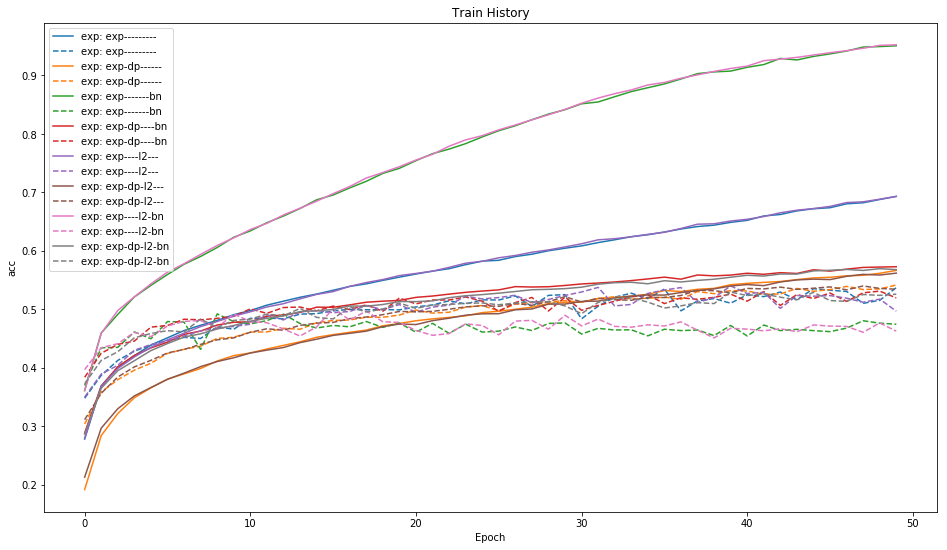

In [9]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, build_params)

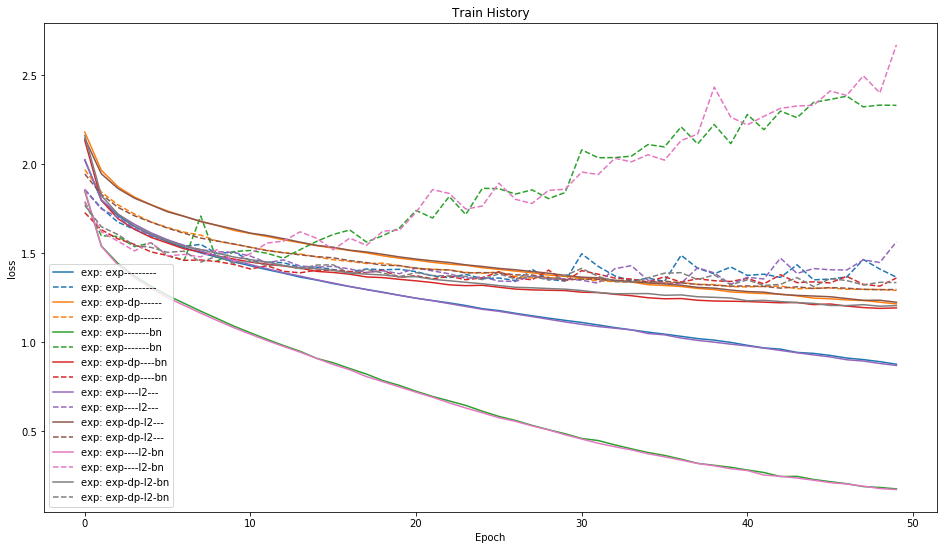

In [10]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, build_params)